# БИЗНЕС-АНАЛИЗ МАРКЕТПЛЕЙСА

Вы — аналитик данных, и сейчас идёте в стартап, который создает новый маркетплейс. Он недавно появился на рынке и занимается продажей новых товаров из Бразилии, которые только начинают поступать в продажу.

Продакт-менеджер Петя переживает за свой продукт, так как выручка маркетплейса стоит на месте уже несколько месяцев. Он предложил вам полную свободу действий. Главное — чтобы метрики росли, а мы не причиняли неудобства клиентам, ведь Петя заботится об их опыте.




## Файлы:

### olist_customers_dataset.csv — таблица с уникальными идентификаторами пользователей

- customer_id — позаказный идентификатор пользователя

- customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)

- customer_zip_code_prefix — почтовый индекс пользователя

- customer_city — город доставки пользователя

- customer_state — штат доставки пользователя

### olist_orders_dataset.csv —  таблица заказов

- order_id — уникальный идентификатор заказа (номер чека)

- customer_id — позаказный идентификатор пользователя

- order_status — статус заказа

- order_purchase_timestamp — время создания заказа

- order_approved_at — время подтверждения оплаты заказа

- order_delivered_carrier_date — время передачи заказа в логистическую службу

- order_delivered_customer_date — время доставки заказа

- order_estimated_delivery_date — обещанная дата доставки

### olist_order_items_dataset.csv — товарные позиции, входящие в заказы

- order_id — уникальный идентификатор заказа (номер чека)

- order_item_id — идентификатор товара внутри одного заказа

- product_id — ид товара (аналог штрихкода)

- seller_id — ид производителя товара

- shipping_limit_date — максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- price — цена за единицу товара

- freight_value — вес товара 



##### Уникальные статусы заказов в таблице olist_orders_dataset:

- created — создан;
- approved — подтверждён;
- invoiced — выставлен счёт;
- processing — в процессе сборки заказа;
- shipped — отгружён со склада;
- delivered — доставлен пользователю;
- unavailable — заказ отменён по причине недоступности товара;;
- canceled — отменён.

### Задача 1. Оценить месячный retention в оформление заказа с помощью когортного анализа.

На первом этапе вы решили посмотреть на метрики маркетплейса и на возвращаемость клиента в продукт.

Для этого вам нужно:

Оценить месячный retention в оформление заказа с помощью когортного анализа, так как важно, чтобы клиенты возвращались в маркетплейс для совершения больших покупок.

В рамках исследования необходимо:

- Исследовать датасет и определить, какой вид заказа будет учитываться в retention
- Построить месячный retention
- Проанализировать, чему равен медианный retention 1-го месяца (т.е. взять retention 1-ого месяца для всех когорт и посчитать по этим числам медиану)
- Найти когорту с самым высоким retention на 3-й месяц.

In [1]:
import pandas as pd
from operator import attrgetter
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np

In [2]:
olist_orders_dataset = pd.read_csv('olist_orders_dataset.csv')

In [3]:
olist_customers_dataset = pd.read_csv('olist_customers_dataset.csv')

In [4]:
olist_customers_dataset.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [146]:
olist_orders_dataset.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [6]:
olist_orders_dataset['order_purchase_timestamp'] = pd.to_datetime(olist_orders_dataset['order_purchase_timestamp'])
olist_orders_dataset['order_approved_at'] = pd.to_datetime(olist_orders_dataset['order_approved_at'])
olist_orders_dataset['order_delivered_carrier_date'] = pd.to_datetime(olist_orders_dataset['order_delivered_carrier_date'])
olist_orders_dataset['order_delivered_customer_date'] = pd.to_datetime(olist_orders_dataset['order_delivered_customer_date'])
olist_orders_dataset['order_estimated_delivery_date'] = pd.to_datetime(olist_orders_dataset['order_estimated_delivery_date'])

In [7]:
# Создаем копию данных, чтобы избежать изменений в исходном DataFrame
data_copy = olist_orders_dataset.copy()

In [8]:
# Объединение файлов по 'customer_id'
merged_data = pd.merge(data_copy, olist_customers_dataset, on='customer_id', how='inner')  

In [9]:
merged_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [10]:
# В retention будут учитываться только доставленные заказы
merged_data = merged_data.query('order_status == "delivered"')

In [11]:
merged_data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [12]:
merged_data = merged_data[['order_purchase_timestamp', 'customer_unique_id']]

In [13]:
merged_data.head()

,order_purchase_timestamp,customer_unique_id
0,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff
1,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231
2,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8
3,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977
4,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6


In [14]:
# Извлекаем месяц и день заказа
merged_data['order_period'] = merged_data['order_purchase_timestamp'].dt.to_period('M')
merged_data['order_period_day'] = merged_data['order_purchase_timestamp'].dt.to_period('D')

In [15]:
merged_data.head()

,order_purchase_timestamp,customer_unique_id,order_period,order_period_day
0,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-10-02
1,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07,2018-07-24
2,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08-08
3,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11-18
4,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02-13


In [16]:
# Присваиваем когорты на основе даты первого действия для каждого пользователя
merged_data['cohort'] = merged_data.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('M')
merged_data['cohort_day'] = merged_data.groupby('customer_unique_id')['order_purchase_timestamp'].transform('min').dt.to_period('D')

In [17]:
merged_data

,order_purchase_timestamp,customer_unique_id,order_period,order_period_day,cohort,cohort_day
0,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-10-02,2017-09,2017-09-04
1,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07,2018-07-24,2018-07,2018-07-24
2,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08-08,2018-08,2018-08-08
3,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11-18,2017-11,2017-11-18
4,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02-13,2018-02,2018-02-13
...,...,...,...,...,...,...
99436,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03-09,2017-03,2017-03-09
99437,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02-06,2018-02,2018-02-06
99438,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08-27,2017-08,2017-08-27
99439,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01-08,2018-01,2018-01-08


In [18]:
# Рассчитываем номер периода в днях (месячные периоды, деля на 30)
merged_data['period_number_month'] = np.floor((merged_data.order_period_day - merged_data.cohort_day).apply(attrgetter('n')) / 30)

In [19]:
merged_data

,order_purchase_timestamp,customer_unique_id,order_period,order_period_day,cohort,cohort_day,period_number_month
0,2017-10-02 10:56:33,7c396fd4830fd04220f754e42b4e5bff,2017-10,2017-10-02,2017-09,2017-09-04,0.0
1,2018-07-24 20:41:37,af07308b275d755c9edb36a90c618231,2018-07,2018-07-24,2018-07,2018-07-24,0.0
2,2018-08-08 08:38:49,3a653a41f6f9fc3d2a113cf8398680e8,2018-08,2018-08-08,2018-08,2018-08-08,0.0
3,2017-11-18 19:28:06,7c142cf63193a1473d2e66489a9ae977,2017-11,2017-11-18,2017-11,2017-11-18,0.0
4,2018-02-13 21:18:39,72632f0f9dd73dfee390c9b22eb56dd6,2018-02,2018-02-13,2018-02,2018-02-13,0.0
...,...,...,...,...,...,...,...
99436,2017-03-09 09:54:05,6359f309b166b0196dbf7ad2ac62bb5a,2017-03,2017-03-09,2017-03,2017-03-09,0.0
99437,2018-02-06 12:58:58,da62f9e57a76d978d02ab5362c509660,2018-02,2018-02-06,2018-02,2018-02-06,0.0
99438,2017-08-27 14:46:43,737520a9aad80b3fbbdad19b66b37b30,2017-08,2017-08-27,2017-08,2017-08-27,0.0
99439,2018-01-08 21:28:27,5097a5312c8b157bb7be58ae360ef43c,2018-01,2018-01-08,2018-01,2018-01-08,0.0


In [20]:
# Агрегируем данные по когортам и рассчитанному номеру периода (в месяцах)
df_cohort = merged_data.groupby(['cohort', 'period_number_month']).agg(n_customers=('customer_unique_id', 'nunique')).reset_index()

In [162]:
df_cohort.head()

,cohort,period_number_month,n_customers
0,2016-09,0.0,1
1,2016-10,0.0,262
2,2016-10,6.0,1
3,2016-10,9.0,1
4,2016-10,11.0,1


In [21]:
# Создаем сводную таблицу для когортного анализа
cohort_pivot = df_cohort.pivot_table(index='cohort', columns='period_number_month', values='n_customers')

In [22]:
cohort_pivot.fillna(0)

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-10,262.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0
2016-12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-01,717.0,2.0,0.0,4.0,1.0,1.0,2.0,2.0,0.0,0.0,...,4.0,3.0,2.0,0.0,2.0,2.0,2.0,1.0,0.0,0.0
2017-02,1628.0,2.0,3.0,6.0,4.0,2.0,4.0,1.0,2.0,4.0,...,6.0,1.0,3.0,2.0,1.0,1.0,3.0,0.0,0.0,0.0
2017-03,2503.0,7.0,13.0,11.0,3.0,2.0,9.0,4.0,6.0,6.0,...,4.0,4.0,3.0,7.0,2.0,3.0,2.0,0.0,0.0,0.0
2017-04,2256.0,8.0,6.0,1.0,6.0,8.0,6.0,10.0,5.0,6.0,...,3.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0
2017-05,3451.0,14.0,14.0,8.0,13.0,11.0,11.0,4.0,10.0,9.0,...,11.0,6.0,3.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0
2017-06,3037.0,13.0,15.0,11.0,5.0,16.0,9.0,6.0,4.0,10.0,...,9.0,3.0,9.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Рассчитываем размеры когорт (первый столбец сводной таблицы)
cohort_size = cohort_pivot.iloc[:, 0]

In [24]:
cohort_size

cohort
2016-09       1.0
2016-10     262.0
2016-12       1.0
2017-01     717.0
2017-02    1628.0
2017-03    2503.0
2017-04    2256.0
2017-05    3451.0
2017-06    3037.0
2017-07    3752.0
2017-08    4057.0
2017-09    4004.0
2017-10    4328.0
2017-11    7060.0
2017-12    5338.0
2018-01    6842.0
2018-02    6288.0
2018-03    6774.0
2018-04    6582.0
2018-05    6506.0
2018-06    5878.0
2018-07    5949.0
2018-08    6144.0
Freq: M, Name: 0.0, dtype: float64

In [25]:
# Вычисляем коэффициенты удержания, деля на размер когорты
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [26]:
retention_matrix.fillna(0).round(4)

period_number_month,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,,
2016-09,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2016-10,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0038,0.0000,0.0000,0.0038,...,0.0038,0.0000,0.0038,0.0000,0.0038,0.0000,0.0038,0.0076,0.0038,0.0038
2016-12,1.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-01,1.0,0.0028,0.0000,0.0056,0.0014,0.0014,0.0028,0.0028,0.0000,0.0000,...,0.0056,0.0042,0.0028,0.0000,0.0028,0.0028,0.0028,0.0014,0.0000,0.0000
2017-02,1.0,0.0012,0.0018,0.0037,0.0025,0.0012,0.0025,0.0006,0.0012,0.0025,...,0.0037,0.0006,0.0018,0.0012,0.0006,0.0006,0.0018,0.0000,0.0000,0.0000
2017-03,1.0,0.0028,0.0052,0.0044,0.0012,0.0008,0.0036,0.0016,0.0024,0.0024,...,0.0016,0.0016,0.0012,0.0028,0.0008,0.0012,0.0008,0.0000,0.0000,0.0000
2017-04,1.0,0.0035,0.0027,0.0004,0.0027,0.0035,0.0027,0.0044,0.0022,0.0027,...,0.0013,0.0000,0.0009,0.0009,0.0009,0.0009,0.0000,0.0000,0.0000,0.0000
2017-05,1.0,0.0041,0.0041,0.0023,0.0038,0.0032,0.0032,0.0012,0.0029,0.0026,...,0.0032,0.0017,0.0009,0.0020,0.0012,0.0000,0.0000,0.0000,0.0000,0.0000
2017-06,1.0,0.0043,0.0049,0.0036,0.0016,0.0053,0.0030,0.0020,0.0013,0.0033,...,0.0030,0.0010,0.0030,0.0013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


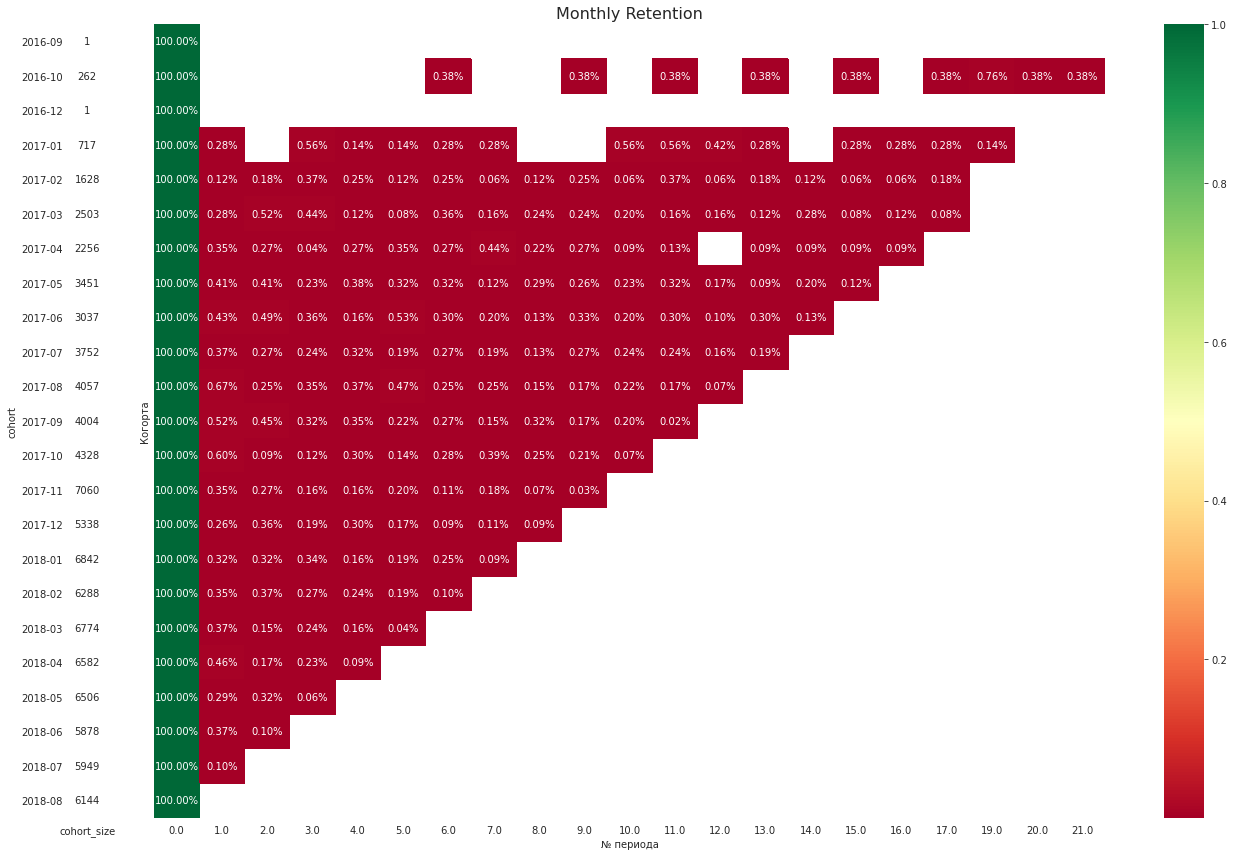

In [27]:
# Строим тепловую карту когортного анализа
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(19, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})

    # Тепловая карта для коэффициентов удержания
    sns.heatmap(retention_matrix,
                mask=retention_matrix.isnull(),
                annot=True,
                fmt='.2%',
                cmap='RdYlGn',
                ax=ax[1])
    ax[1].set_title('Monthly Retention', fontsize=16)
    ax[1].set(xlabel='№ периода', ylabel='Когорта')

    # Тепловая карта для размеров когорт
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df,
                annot=True,
                cbar=False,
                square = True,
                fmt='g',
                cmap=white_cmap,
                ax=ax[0])

    fig.tight_layout()
    plt.show()

Судя по красной тепловой карте, возвращаемость клиента в продукт очень низкая. Построим ещё одну тепловую карту без учёта нулевого месяца, чтобы оценить цветовую разницу возвращаемости клиентов в продукт по месяцам. 

In [29]:
# Удаляем нулевой месяц 
df_heatmap = retention_matrix.iloc[:, 1:]

In [30]:
df_heatmap.fillna(0).style.background_gradient(axis = None, cmap = 'Greens').set_precision(4)

period_number_month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,19.0,20.0,21.0
cohort,,,,,,,,,,,,,,,,,,,,
2016-09,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2016-10,0.0000,0.0000,0.0000,0.0000,0.0000,0.0038,0.0000,0.0000,0.0038,0.0000,0.0038,0.0000,0.0038,0.0000,0.0038,0.0000,0.0038,0.0076,0.0038,0.0038
2016-12,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2017-01,0.0028,0.0000,0.0056,0.0014,0.0014,0.0028,0.0028,0.0000,0.0000,0.0056,0.0056,0.0042,0.0028,0.0000,0.0028,0.0028,0.0028,0.0014,0.0000,0.0000
2017-02,0.0012,0.0018,0.0037,0.0025,0.0012,0.0025,0.0006,0.0012,0.0025,0.0006,0.0037,0.0006,0.0018,0.0012,0.0006,0.0006,0.0018,0.0000,0.0000,0.0000
2017-03,0.0028,0.0052,0.0044,0.0012,0.0008,0.0036,0.0016,0.0024,0.0024,0.0020,0.0016,0.0016,0.0012,0.0028,0.0008,0.0012,0.0008,0.0000,0.0000,0.0000
2017-04,0.0035,0.0027,0.0004,0.0027,0.0035,0.0027,0.0044,0.0022,0.0027,0.0009,0.0013,0.0000,0.0009,0.0009,0.0009,0.0009,0.0000,0.0000,0.0000,0.0000
2017-05,0.0041,0.0041,0.0023,0.0038,0.0032,0.0032,0.0012,0.0029,0.0026,0.0023,0.0032,0.0017,0.0009,0.0020,0.0012,0.0000,0.0000,0.0000,0.0000,0.0000
2017-06,0.0043,0.0049,0.0036,0.0016,0.0053,0.0030,0.0020,0.0013,0.0033,0.0020,0.0030,0.0010,0.0030,0.0013,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


На данной тепловой карте видно, что чаще всего retention в первые три месяца чуть выше остальных периодов, однако иногда бывают исключения в виде относительно высоких значений на 10-11, 19 месяцы и др.

- Найдём когорту с самым высоким retention на 3-й месяц

In [172]:
max_retention_cohort = retention_matrix.iloc[:, 3].idxmax()
max_retention_value = retention_matrix.iloc[:, 3].max()

print(f"Когорта с самым высоким retention на 3-й месяц: {max_retention_cohort}")
print(f"Значение retention: {max_retention_value:.2%}")

Когорта с самым высоким retention на 3-й месяц: 2017-01
Значение retention: 0.56%


- Найдём медианный retention 1-го месяца

In [173]:
# Извлекаем retention 1-го месяца
first_month_retention = retention_matrix.iloc[:, 1]  # 1-й месяц имеет индекс 1

# Рассчитываем медиану
median_first_month_retention = first_month_retention.median()
print(f"Медианный retention 1-го месяца: {median_first_month_retention: }")

Медианный retention 1-го месяца:  0.0035460992907801418


### Задача 2. Определить, существует ли product/market fit у маркетплейса.

Построив retention, вы решили оценить, насколько хорошо продукт закрывает потребности клиента.

Для этого вам нужно:

Определить, существует ли product/market fit у этого маркетплейса. Ведь до сих пор непонятно, можно ли масштабировать подобный продукт на новые рынки. Есть вероятность, что маркетплейс будет приносить убытки.

В рамках исследования необходимо:

Оценить наличие product/market fit у данного продукта с помощью когортного анализа, полученного на предыдущем шаге.
Пояснить свою позицию и сформулировать, на чём маркетплейс должен сконцентрироваться в ближайшее время. Если PMF есть, то в какую сторону лучше развивать продукт дальше? Если PMF нет, то какие причины могут быть у этого?

#### Анализ данных

- #### Retention на 3-й месяц:
Retention на 3-й месяц для большинства когорт находится на низком уровне (в среднем около 0.2%-0.5%).
Это указывает на то, что пользователи быстро теряют интерес к продукту после первых месяцев использования.
- #### Долгосрочный Retention:
Retention после 6-го месяца практически отсутствует для большинства когорт (значения близки к 0%).
Это говорит о том, что продукт не удерживает пользователей в долгосрочной перспективе.
- #### Исключения:
Некоторые когорты, например, 2017-01 и 2017-02, показывают чуть более высокий retention на 3-й месяц (около 0.5%-0.6%), но это всё ещё слишком низкий показатель для уверенного наличия PMF.
- #### Вывод о наличии PMF
На основе когортного анализа можно сделать вывод о том, что Product/Market Fit (PMF) у маркетплейса отсутствует. За всё время менее 1 % пользователей сделали повторныцй заказ. Такой низкий уровень retention указывает на то, что продукт не удовлетворяет потребности пользователей или не предоставляет достаточной ценности, чтобы они продолжали его использовать. Таким образом, масштабировать подобный продукт на новые рынки ещё рано.


#### Возможные причины отсутствия PMF
- ##### Недостаточная ценность продукта:

Продукт может не решать ключевые проблемы пользователей или не предоставлять уникальных преимуществ по сравнению с конкурентами, из-за чего пользователи не видят причин возвращаться к продукту после первого использования.
- ##### Проблемы с пользовательским опытом:

Сложный интерфейс, неудобная навигация или технические проблемы могут отпугивать пользователей.
- ##### Неправильная целевая аудитория:

Продукт может быть ориентирован на аудиторию, которая не испытывает острой потребности в его использовании.
- ##### Высокая конкуренция:

Если на рынке есть более удобные или дешёвые альтернативы, пользователи могут предпочесть их.

#### Рекомендации для улучшения
- ##### Проведение исследований пользователей:

Стоит провести опросы и интервью с текущими и бывшими пользователями, чтобы понять их потребности, ожидания и причины отказа от продукта.
- ##### Улучшение ключевых функций:

Нужно сосредоточиться на улучшении тех функций, которые наиболее важны для пользователей. Например, упростить процесс покупки, добавить больше товаров или улучшить доставку.
- ##### Повышение вовлечённости:

Необходимо внедрить механизмы, которые стимулируют пользователей возвращаться к продукту (например, программы лояльности, персонализированные рекомендации, акции).
- ##### Тестирование гипотез:

Нужно провести A/B тесты, чтобы проверить, какие изменения в продукте могут повысить retention.
- ##### Фокус на узкой аудитории:

Возможно стоит сосредоточиться на конкретной нише или сегменте пользователей, которые могут быть наиболее заинтересованы в продукте.


### Задача 3. Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

Вы разобрались с наличием product/market fit. Теперь вас просят сформулировать продуктовые метрики маркетплейса, чтобы компания могла на них ориентироваться.

В первую очередь необходимо:

Определить 5 основных метрик, на которых продакт может сконцентрироваться, чтобы максимизировать прибыль компании.

- Первая метрика должна отражать рост объёма продаж маркетплейса.
- Вторая — показывать объем аудитории, которой продукт доставляет ценность.
- Третья — отражать заинтересованность новых клиентов в продакте.
- Четвёртая — отражать вовлеченность клиента в продолжение использования продукта.
- Пятая — отражать денежное выражение вовлеченности клиента.
- Визуализируйте первую, вторую, четвёртую и пятую метрики. Используйте месячную гранулярность и окно в 1 месяц, если это нужно.

In [174]:
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


##### 1. Объем продаж маркетплейса

In [175]:
# Создание столбца с месяцем и годом
olist_orders_dataset['order_month'] = olist_orders_dataset['order_purchase_timestamp'].dt.to_period('M')

In [176]:
olist_orders_dataset.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02


In [177]:
olist_orders_dataset.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_month                           period[M]
dtype: object

In [178]:
olist_order_items_dataset = pd.read_csv('olist_order_items_dataset.csv')

In [179]:
olist_order_items_dataset.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [180]:
# Объединение файлов по 'order_id'
orders_items = pd.merge(olist_order_items_dataset, olist_orders_dataset, on='order_id', how='inner')  

In [181]:
orders_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,2017-04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,2018-01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,2017-02


In [182]:
# Объем продаж
sales_volume = orders_items.groupby('order_month', as_index = False) \
    .agg(sales=('price', 'sum')) 
# Преобразование 'order_month' в timestamp
sales_volume['order_month'] = sales_volume['order_month'].dt.to_timestamp()

In [183]:
sales_volume

,order_month,sales
0,2016-09-01,267.36
1,2016-10-01,49507.66
2,2016-12-01,10.90
3,2017-01-01,120312.87
4,2017-02-01,247303.02
5,2017-03-01,374344.30
6,2017-04-01,359927.23
7,2017-05-01,506071.14
8,2017-06-01,433038.60
9,2017-07-01,498031.48


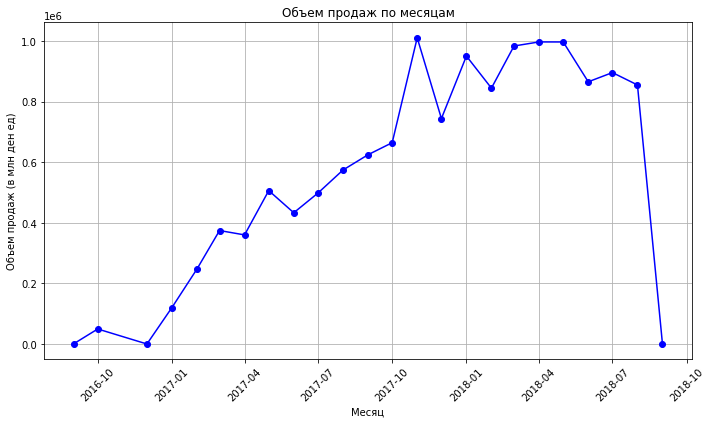

In [184]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(sales_volume['order_month'], sales_volume['sales'], marker='o', linestyle='-', color='b')
plt.title('Объем продаж по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Объем продаж (в млн ден ед)')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

По графику видно, что объём продаж постепенно растёт, выходит на плато, однако резко падает к октябрю 2018 года.

##### 2. Количество уникальных активных клиентов в месяц

In [185]:
# Объем аудитории
unique_customers = merged_data.groupby('order_period', as_index = False).agg(MAU = ('customer_unique_id', 'nunique'))
# Преобразование 'order_period' в timestamp
unique_customers['order_period'] = unique_customers['order_period'].dt.to_timestamp()
unique_customers

,order_period,MAU
0,2016-09-01,1
1,2016-10-01,262
2,2016-12-01,1
3,2017-01-01,718
4,2017-02-01,1630
5,2017-03-01,2508
6,2017-04-01,2274
7,2017-05-01,3479
8,2017-06-01,3076
9,2017-07-01,3802


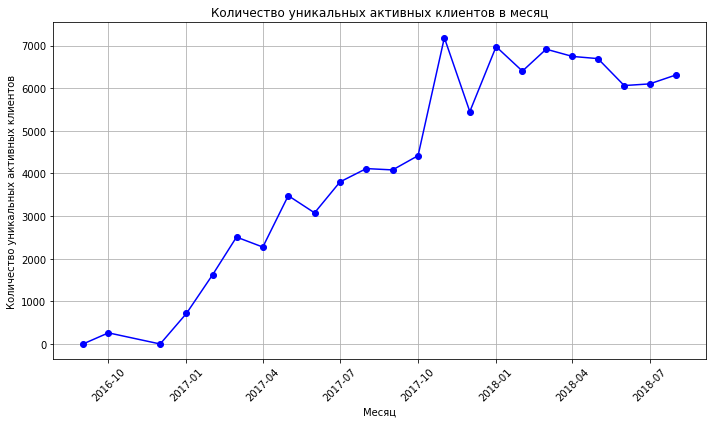

In [186]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(unique_customers['order_period'], unique_customers['MAU'], marker='o', linestyle='-', color='b')
plt.title('Количество уникальных активных клиентов в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных активных клиентов')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

На данной графике отображены активные клиенты по месяцам, которые совершили и получили хотя бы один заказ за месяц (здесь учитываются только доставленные заказы). Количество активных клиентов постепнно растёт, однако к январю 2018 года выходит на плато, имея небольшие колебания.

Теперь оценим динамику количества активных клиентов, которые имели любое взаимодействие с маркетплейсом в течение месяца (учитываются все статусы заказов):

In [187]:
customers_orders = pd.merge(olist_orders_dataset, olist_customers_dataset, on='customer_id', how='inner')  

In [188]:
customers_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2017-10,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,2018-07,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,2018-08,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,2017-11,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2018-02,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [189]:
# Объем аудитории
unique_customers_all_status = customers_orders.groupby('order_month', as_index = False).agg(MAU = ('customer_unique_id', 'nunique'))
# Преобразование 'order_period' в timestamp
unique_customers_all_status['order_month'] = unique_customers_all_status['order_month'].dt.to_timestamp()
unique_customers_all_status

,order_month,MAU
0,2016-09-01,4
1,2016-10-01,321
2,2016-12-01,1
3,2017-01-01,765
4,2017-02-01,1755
5,2017-03-01,2642
6,2017-04-01,2372
7,2017-05-01,3625
8,2017-06-01,3180
9,2017-07-01,3947


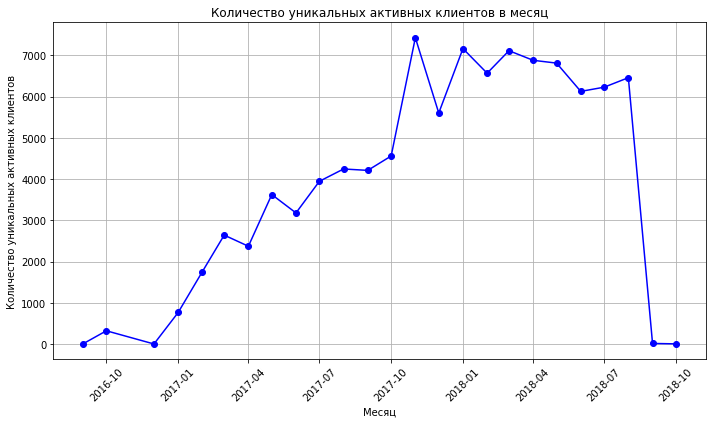

In [190]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(unique_customers_all_status['order_month'], unique_customers_all_status['MAU'], marker='o', linestyle='-', color='b')
plt.title('Количество уникальных активных клиентов в месяц')
plt.xlabel('Месяц')
plt.ylabel('Количество уникальных активных клиентов')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

Количество активных клиентов, имевших любого рода взаимодействие с продуктом, также постепенно увеличивается, но резко снижается в сентябре-октябре 2018 года

##### 3. Количество новых клиентов, сделавших первый заказ в текущем месяце

In [191]:
# Определение новых клиентов
# Сначала создаем DataFrame с уникальными клиентами и их первыми заказами
first_orders = customers_orders.groupby('customer_unique_id')['order_purchase_timestamp'].min().reset_index()
first_orders.columns = ['customer_unique_id', 'first_order_date']

first_orders.head()

,customer_unique_id,first_order_date
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [192]:
# Объединяем с оригинальной таблицей, чтобы получить месяц первого заказа
first_orders['first_order_month'] = first_orders['first_order_date'].dt.to_period('M')

first_orders.head()

,customer_unique_id,first_order_date,first_order_month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11


In [193]:
# Считаем количество новых клиентов по месяцам
new_customers = first_orders.groupby('first_order_month', as_index = False).agg(new_customers = ('customer_unique_id', 'count'))

new_customers

,first_order_month,new_customers
0,2016-09,4
1,2016-10,321
2,2016-12,1
3,2017-01,764
4,2017-02,1752
5,2017-03,2636
6,2017-04,2352
7,2017-05,3596
8,2017-06,3139
9,2017-07,3894


Значения new_customers довольно схожи с MAU, что свидетельствует об очень низком retention, т. е. с каждым месяцем просто постепенно растёт число новых клиентов, которые единоразово осуществляют покупку и больше не пользуются данным маркетплейсом.

##### 4. Среднее количество заказов на одного клиента за месяц.  


In [195]:
# Вовлеченность клиента
orders_per_customer = customers_orders.groupby('order_month', as_index = False).agg(num_orders = ('order_id', 'count')) 
orders_per_customer.head()

,order_month,num_orders
0,2016-09,4
1,2016-10,324
2,2016-12,1
3,2017-01,800
4,2017-02,1780


In [196]:
orders_per_customer['avg_orders'] = orders_per_customer['num_orders'] / unique_customers_all_status['MAU']

In [197]:
orders_per_customer.head()

,order_month,num_orders,avg_orders
0,2016-09,4,1.000000
1,2016-10,324,1.009346
2,2016-12,1,1.000000
3,2017-01,800,1.045752
4,2017-02,1780,1.014245


In [198]:
orders_per_customer = orders_per_customer[['order_month', 'avg_orders']]

In [199]:
orders_per_customer['order_month'] = orders_per_customer['order_month'].dt.to_timestamp()
orders_per_customer.head()

,order_month,avg_orders
0,2016-09-01,1.000000
1,2016-10-01,1.009346
2,2016-12-01,1.000000
3,2017-01-01,1.045752
4,2017-02-01,1.014245


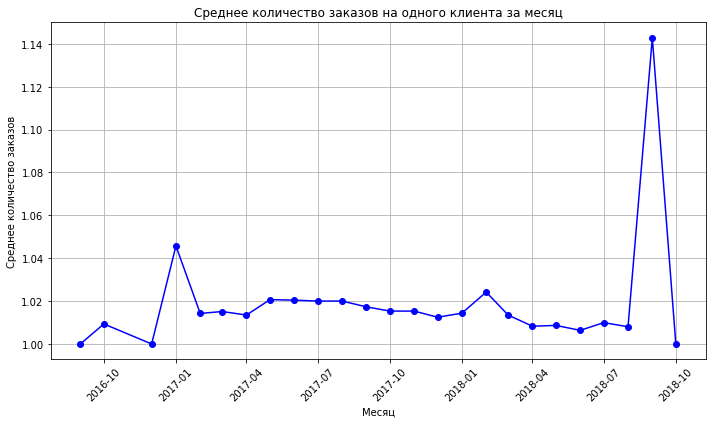

In [200]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(orders_per_customer['order_month'], orders_per_customer['avg_orders'], marker='o', linestyle='-', color='b')
plt.title('Среднее количество заказов на одного клиента за месяц')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество заказов')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

В среднем, один клиент совершает один заказ в месяц. И, как было выяснено ранее, в следующих периодах не заказывает больше товары с данного маркетплейса.

##### 5. Cредняя выручка на одного пользователя

In [201]:
# Объединение файлов по 'order_month'
arpu = pd.merge(sales_volume, unique_customers_all_status, on='order_month', how='inner')  

In [202]:
arpu.head()

,order_month,sales,MAU
0,2016-09-01,267.36,4
1,2016-10-01,49507.66,321
2,2016-12-01,10.90,1
3,2017-01-01,120312.87,765
4,2017-02-01,247303.02,1755


Метрика: Средний доход на одного клиента (ARPU - Average Revenue Per User).  

In [203]:
# 5. Денежное выражение вовлеченности клиента
arpu['ARPU'] = arpu['sales'] / arpu['MAU']

In [204]:
arpu.head()

,order_month,sales,MAU,ARPU
0,2016-09-01,267.36,4,66.840000
1,2016-10-01,49507.66,321,154.229470
2,2016-12-01,10.90,1,10.900000
3,2017-01-01,120312.87,765,157.271725
4,2017-02-01,247303.02,1755,140.913402


In [205]:
arpu = arpu[['order_month', 'ARPU']]
#arpu['order_month'] = arpu['order_month'].dt.to_timestamp()
arpu.head()

,order_month,ARPU
0,2016-09-01,66.840000
1,2016-10-01,154.229470
2,2016-12-01,10.900000
3,2017-01-01,157.271725
4,2017-02-01,140.913402


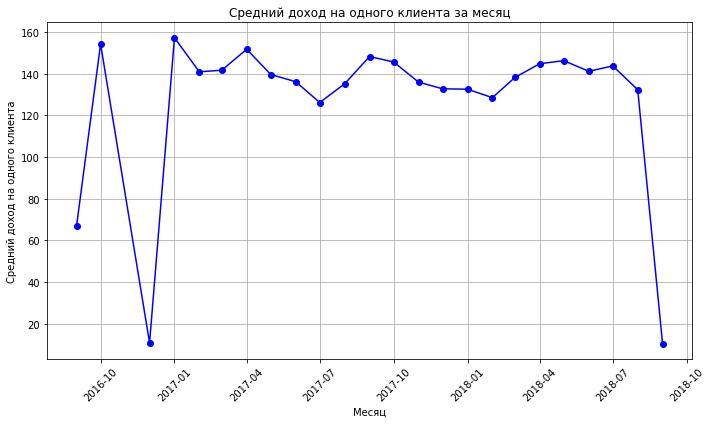

In [206]:
# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(arpu['order_month'], arpu['ARPU'], marker='o', linestyle='-', color='b')
plt.title('Средний доход на одного клиента за месяц')
plt.xlabel('Месяц')
plt.ylabel('Средний доход на одного клиента')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

В среднем,один клиент приносит маркетплейсу около 130-150 денежных единиц за месяц. Заметно резкое снижение среднего чека в начале и в конце деятельности продукта.

### Задача 4. Выбрать одну из 3 основных гипотез с помощью фреймворка ICE.

Посмотрев с продактом на когортный анализ и метрики, вы решили, что нужно изменить продукт. Метрики необходимо срочно повышать. Вместе с командой вы сформулировали 3 гипотезы, в которые вы верите. По каждой гипотезе команда заполнила показатели по Ease, Confidence. Вам нужно заполнить самый важный показатель — Impact. Для этого вам требуется:

Выбрать одну из трёх основных гипотез с помощью фреймворка ICE, которые были сформированы продактом и, кажется, должны улучшить пользовательский опыт в маркетплейсе.

Для расчёта Impact возьмите данные с июня 2017 года. Считайте, что конверсия в повторный заказ равна величине медианного retention 1-го месяца (см. пункт 1 проекта).

In [208]:
# Извлекаем retention 1-го месяца
first_month_retention = retention_matrix.iloc[:, 1]  # 1-й месяц имеет индекс 1

# Рассчитываем медиану
median_first_month_retention = first_month_retention.median()
print(f"Медианный retention 1-го месяца: {median_first_month_retention: }")

Медианный retention 1-го месяца:  0.0035460992907801418


#### Гипотеза 1
Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

С помошью исправления бага, мы увеличим количество доставленных заказов на число ранее отменённых заказов. Значит, нужно посчитать количество отменённых заказов, начиная с июня 2017 года (так сказано по условию).

In [211]:
customers_orders.query('order_status == "canceled" & order_month > "2017-05"').order_id.count() 

499

Получили 499 отменённых заказов, что соответствует "4" по impact

In [218]:
ICE_1 = 4 * 8 * 6
ICE_1

192

In [224]:
499 * median_first_month_retention

1.7695035460992907

Это мы посчитали, что около двух клиентов станут потом регулярно заказывать товары с маркетплейса, если исправить баг в системе процессинга заказов.

In [225]:
ICE_1 = 1 * 8 * 6
ICE_1

48

ICE_1 = 48 с расчётом на то, что количество заказов увеличится за счёт повторных заказов. 

#### Гипотеза 2
Если сократим время до отгрузки заказа, то клиенты перестанут получать свой заказ с запаздыванием, вследствие чего количество заказов увеличится за счёт повторных заказов. Считаем, что мы таким образом избавимся от всех отмен.

Найдём для начала количество отменённых заказов, у которых предполагаемая дата доставки оказалась меньше реального даты доставки заказа, то есть заказ пришёл с опозданием. Мы предполагаем, что именно задержка доставки заказа послужила причиной его отмены. 

In [214]:
customers_orders \
    .query('order_estimated_delivery_date < order_delivered_customer_date & order_month > "2017-05" & order_status == "canceled"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_month,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,2018-02,6a04c8339c44b23e189446216a494569,32071,contagem,MG


Выяснилось, что только 1 заказ был отменён из-за задержки доставки. То есть если мы сократим время до отгрузки товара, то мы получим +1 нового платящего клиента.

In [215]:
customers_orders \
    .query('order_estimated_delivery_date < order_delivered_customer_date & order_month > "2017-05" & order_status == "delivered"') \
    .customer_unique_id.count()

7295

7295 заказов были успешно доставлены с опозданием.

Подразумевается, что клиенты, которые получили заказ вовремя вероятнее вернуться за покупками в очередной раз. Посчитаем количество вернувшихся клиентов, как долю тех, кто получит заказ вовремя (1+7295) от конверсии в повторный заказ:

In [216]:
7296 * median_first_month_retention

25.872340425531913

Получили примерно 26 новых повторно платящих пользователей, что соответсвует "1" по шкале impact.

In [217]:
ICE_2 = 1 * 10 * 4
ICE_2

40

#### Гипотеза 3
Если создадим новый способ оплаты, который будет конвертировать клиентов в повторный заказ, то клиенты не будут испытывать трудности при оформлении заказа, вследствие чего количество заказов увеличится за счёт повторных заказов.

Будем считать, что клиенты, испытывающие трудности при оформлении заказа - это те, у которых заказ отменён по причине отсуствия времени подтверждения оплаты заказа. Возможно они не смогли удобным для себя способом оплатить заказ и поэтому не заказали товар.

In [222]:
customers_orders \
    .query('order_status == "canceled" & order_month > "2017-05" & order_approved_at == "NaT"') \
    .customer_unique_id.count()

117

Получили 117 клиентов, которые испытывали проблемы при оформлении заказа. Найдём примерное число тех, кто из 117 теперь вернётся за очередными покупками на данный маркетплейс:

In [223]:
117 * median_first_month_retention

0.4148936170212766

Всего ничего клиентов будут готовы вернуться за покупками, что соответствует "1" по шкале impact

In [226]:
ICE_3 = 1 * 5 * 9
ICE_3

45

#### Вывод
С помощью фреймворка ICE выбираем первую гипотезу:

- Если исправим баг в системе процессинга заказов, то клиентам не придётся сталкиваться с проблемой отмены заказа, вследствие чего количество доставленных заказов увеличится. Считаем, что мы таким образом избавимся от всех отмен.

### Задача 5. Сформулировать нужные метрики, на которые ваша гипотеза должна повлиять.

После предыдущего исследования у вас появилась гипотеза, которую можно реализовать для значительного улучшения метрик компании. Вы предложили использовать A/B-тестирование для проверки её эффективности.

Продакт попросил вас:

Сформулировать метрики, на которые должна повлиять выбранная вами гипотеза.
Сформулировать хотя бы по одной метрике в категории: целевые, прокси, guardrail.

1. Целевые метрики
Целевые метрики напрямую отражают успех гипотезы и измеряют основную цель.
Количество доставленных заказов:
Это ключевая метрика, так как гипотеза направлена на увеличение числа успешно доставленных заказов.
Формула: Количество доставленных заказов / Общее количество заказов × 100%.
Ожидаемое изменение: рост метрики после исправления бага.
Снижение процента отмен заказов:
Поскольку гипотеза предполагает устранение всех отмен, эта метрика должна значительно уменьшиться.
Формула: Количество отмененных заказов / Общее количество заказов × 100%.
2. Прокси-метрики
Прокси-метрики помогают оценить промежуточные изменения, которые могут быть связаны с целевыми метриками.
Время обработки заказа:
Если баг в системе процессинга заказов исправлен, время обработки заказа должно сократиться.
Формула: Среднее время от момента оформления заказа до его подтверждения.
Процент успешных транзакций:
Если баг влияет на процессинг заказов, то исправление должно повысить долю успешных транзакций.
Формула: Количество успешных транзакций / Общее количество транзакций × 100%.
3. Guardrail-метрики
Guardrail-метрики помогают убедиться, что изменения не оказывают негативного влияния на другие аспекты бизнеса.
Средний чек (AOV, Average Order Value):
Важно убедиться, что исправление бага не снижает средний чек клиента.
Формула: Общая сумма заказов / Количество заказов.
Удовлетворенность клиентов (NPS или CSAT):
Исправление бага не должно ухудшить пользовательский опыт. Например, если исправление приводит к другим проблемам, это может отразиться на оценках клиентов.
Измеряется через опросы клиентов.
Процент возвратов:
Убедитесь, что исправление бага не приводит к увеличению возвратов заказов.
Формула: Количество возвратов / Общее количество доставленных заказов × 100%.

### Задача 6. Вот и подошёл к концу ваш первый этап работы аналитиком в команде маркетплейса. Теперь необходимо поделиться результатами проведённой работы с компанией.


Сформулируйте выводы о проделанной работе, опишите их в комментариях в ipynb-файле или описании мердж-реквеста. 
Структура должна выглядеть следующим образом:
   - формализация проблемы продукта;

   - описание выводов из пункта 1;

   - описание выводов из пункта 2;

   - описание выводов из пункта 3;

   - описание выводов из пункта 4;

   - описание выводов из пункта 5;

   - общие выводы по итогу исследования;

   - рекомендации по продукту.